In [3]:
import sys
print(sys.executable)

/home/at3ee/anaconda3/bin/python


In [8]:
import arviz as az
import theano
import pymc3 as pm


In [9]:
az.style.use("arviz-darkgrid")

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

plt.style.use("ggplot")
warnings.filterwarnings('ignore')


## Dataset
The Eight Schools problem is a study of SAT coaching effects from eight schools [[1]](#References). For each the eight schools `num_schools` we have the estimated treatment effect (`treatment_effects`) and standard error of the effect estimate (`treatment_stddevs`).

In [7]:
num_schools = 8  # number of schools
treatment_effects = np.array(
    [28, 8, -3, 7, -1, 1, 18, 12], dtype=np.float32)  # estimated treatment effect
treatment_stddevs = np.array(
    [15, 10, 16, 11, 9, 11, 10, 18], dtype=np.float32)  # treatment SE


Below is a boxplot of the data:

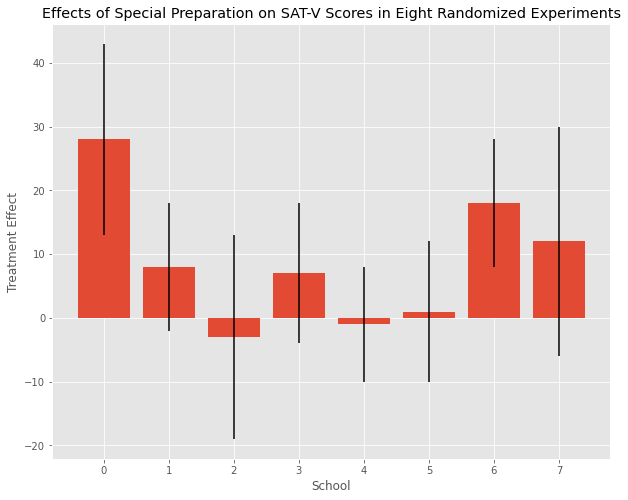

In [5]:
num_schools = 8  # number of schools
treatment_effects = np.array(
    [28, 8, -3, 7, -1, 1, 18, 12], dtype=np.float32)  # treatment effects
treatment_stddevs = np.array(
    [15, 10, 16, 11, 9, 11, 10, 18], dtype=np.float32)  # treatment SE

fig, ax = plt.subplots()
plt.bar(range(num_schools), treatment_effects, yerr=treatment_stddevs)
plt.title("Effects of Special Preparation on SAT-V Scores in Eight Randomized Experiments")
plt.xlabel("School")
plt.ylabel("Treatment Effect")
fig.set_size_inches(10, 8)
plt.show()


## 1. Non-centered Parameterization
Let, ${\mathcal D}=\{x_{i}\}_{i=1}^{8}$ a set of observations, where each $x_i$ is a observed random variable (RV).
$$
x_i \sim \mathcal{N}\left(\theta_i, \sigma_i \right)
$$

Declare $\mathbf{\Theta} = \left\{ \theta_i \right\}_{i=1}^8 $ used ton calculate the probabilities of observed RVs. 

$$
\theta_i = \mu + \tau * \eta_i
$$

where, $\eta_i \sim \mathcal{N}(0, 1)$ and $\mathbf{\eta} = \{ \eta \}_{i=1}^8 $. Also $\mathbf{\phi} = \left\{\mu, \tau, \mathbf{\eta} \right\}$ parameterizing $\mathbf{\Theta}$.
### 1.1. Variational inference


In [11]:
# Parameterization by MCMC
with pm.Model() as model:
    eta = pm.Normal("eta", 0, 1, shape=num_schools)
    mu = pm.Normal("mu", 0, sigma=10)
    tau = pm.HalfNormal("tau", 10)

    theta = pm.Deterministic("theta", mu + tau * eta)

    obs = pm.Normal("obs", theta, sigma=treatment_stddevs, observed=treatment_effects)

    trace_h = pm.sample(2000, target_accept=0.95, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, mu, eta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.


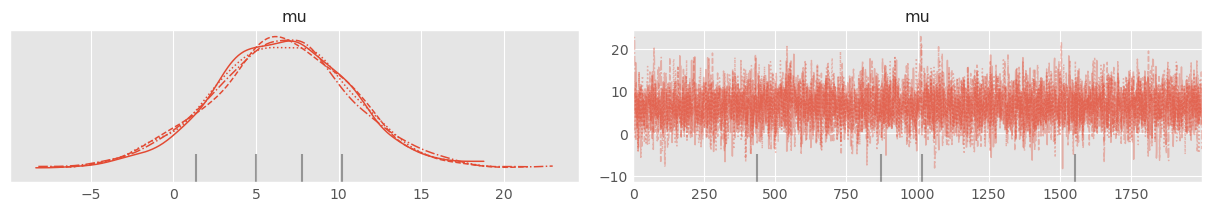

In [15]:
az.plot_trace(trace_h, var_names="mu");

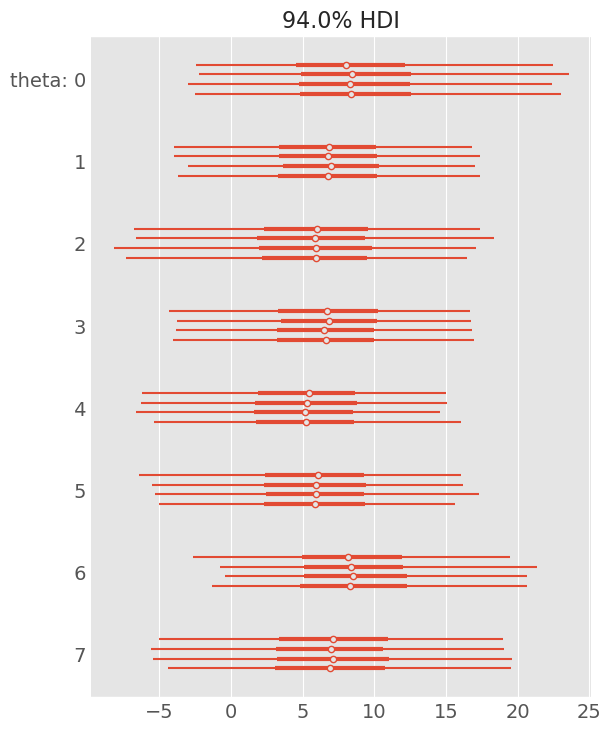

In [17]:
az.plot_forest(trace_h, var_names="theta");

### 1.2. ADVI Inference 


In [12]:
with model:
    mean_field = pm.fit(method="advi")

Finished [100%]: Average Loss = 32.567


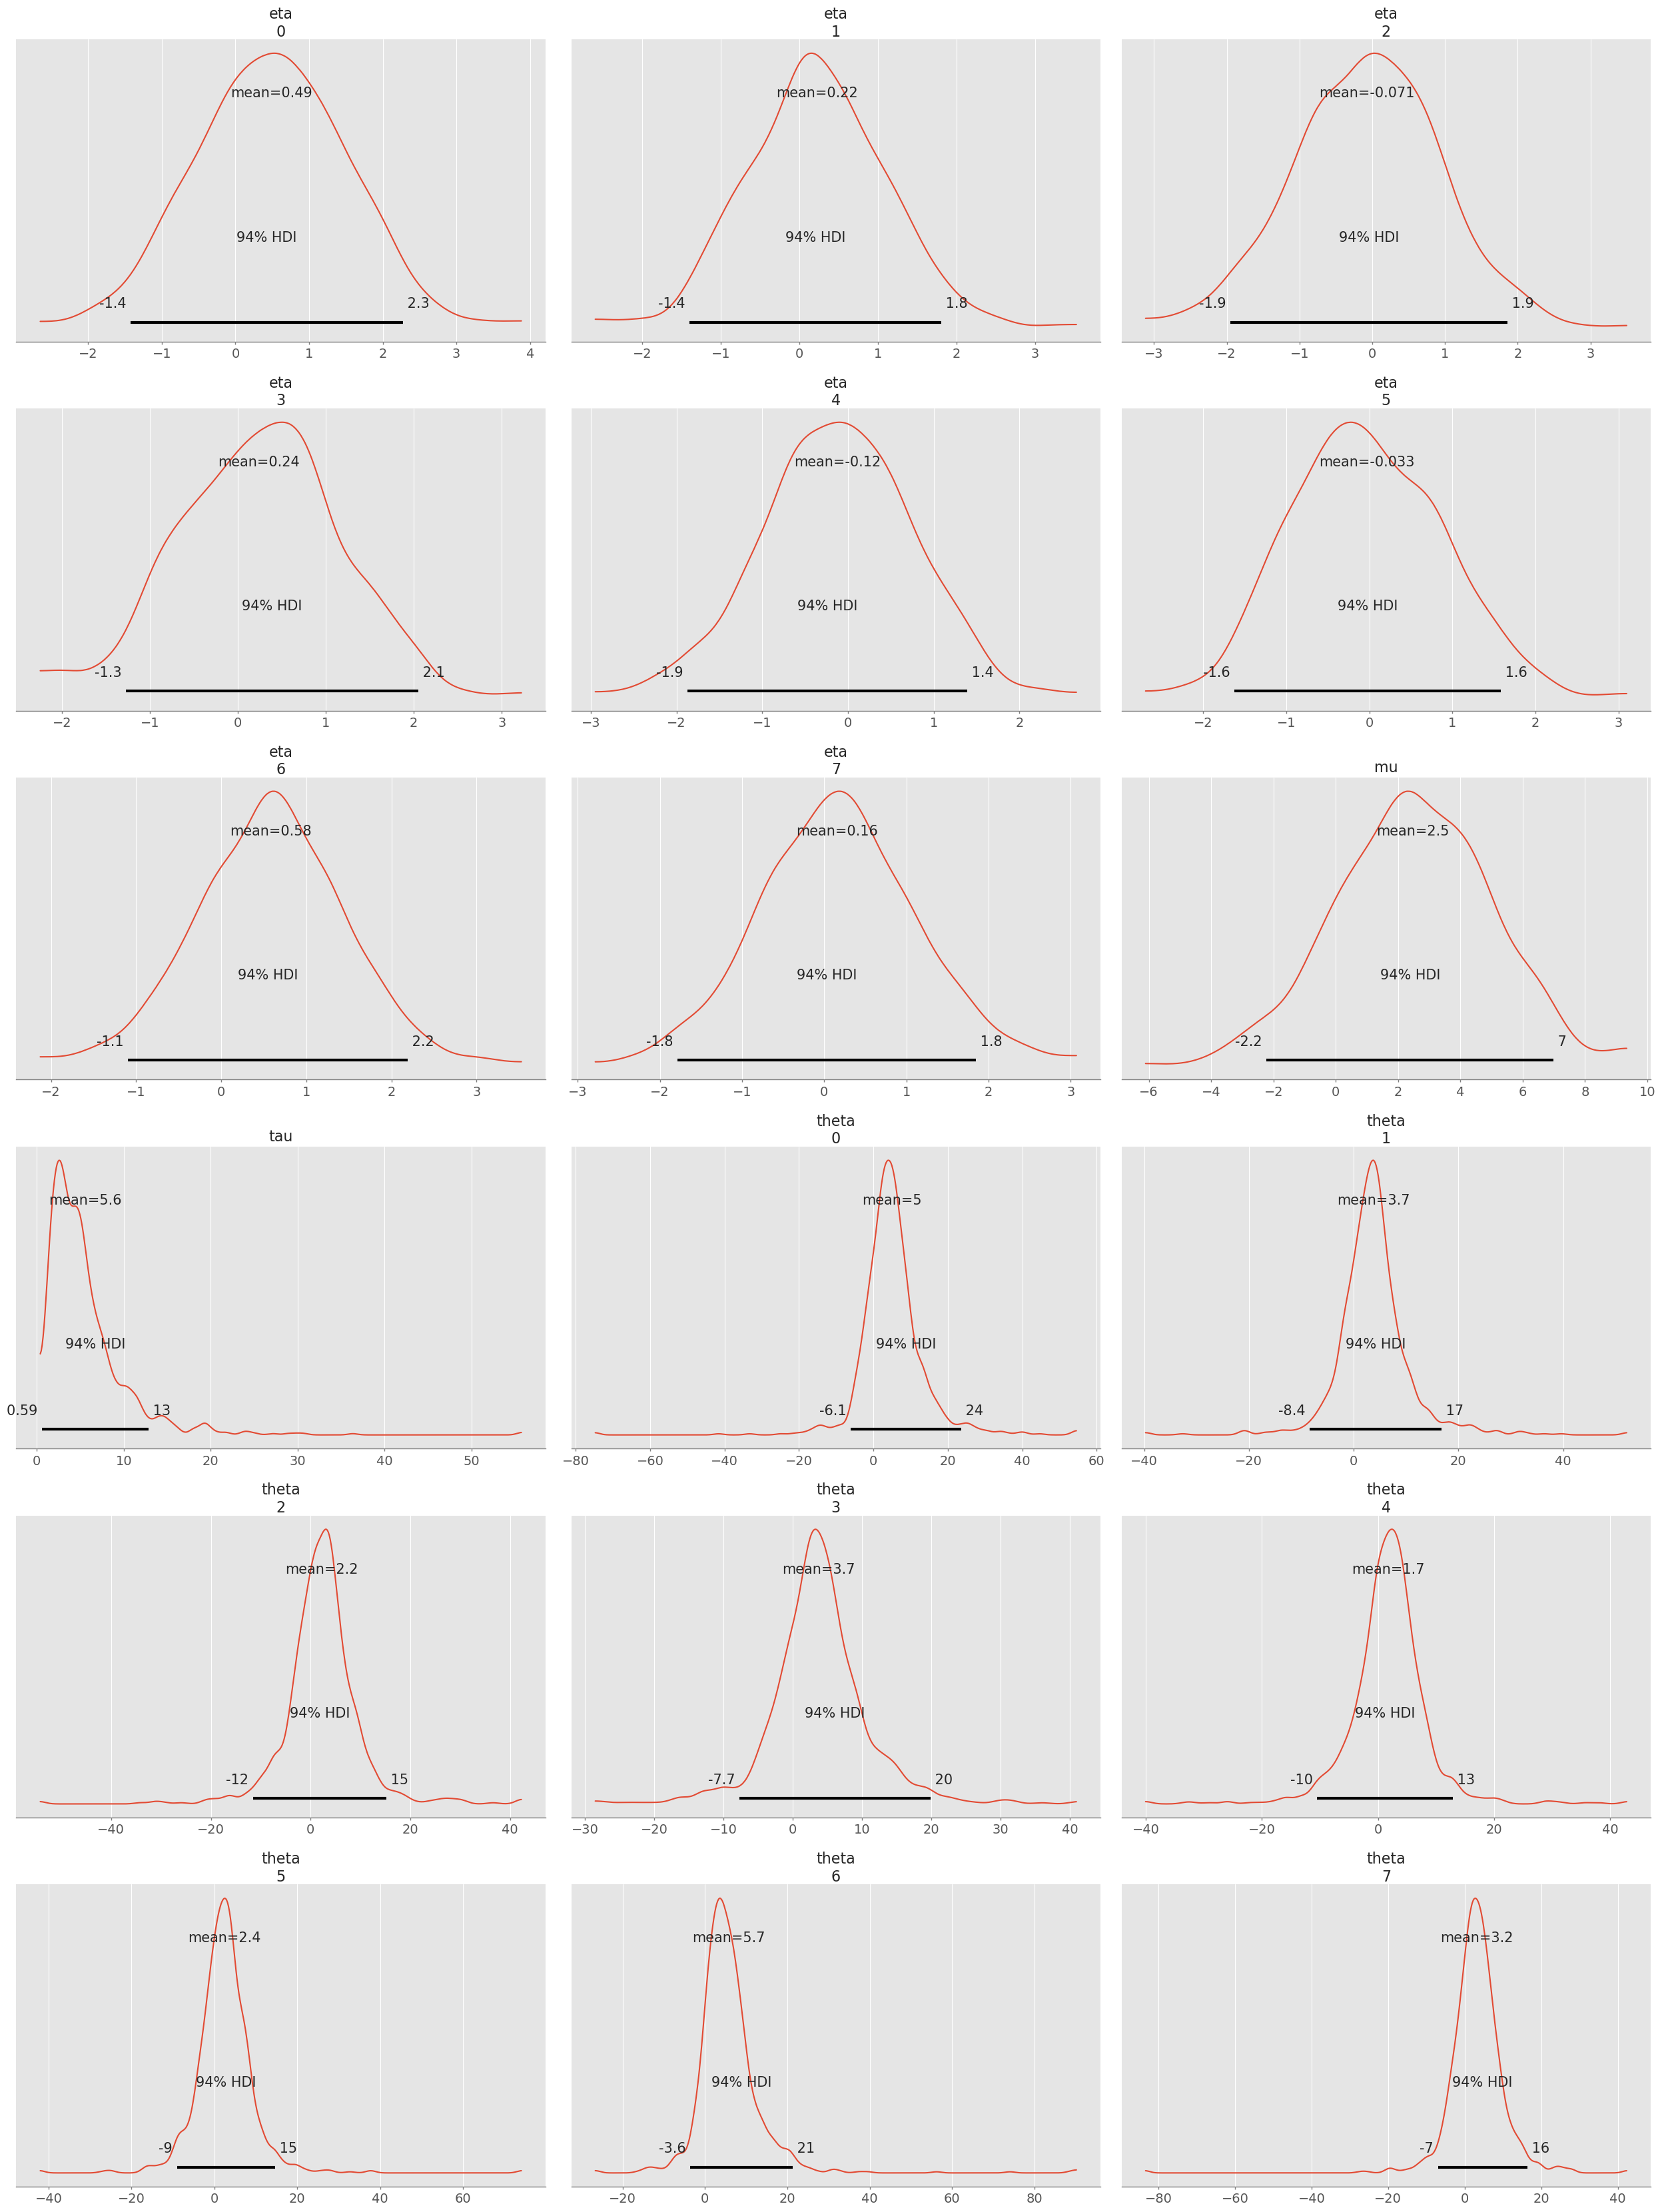

In [15]:
pm.plot_posterior(mean_field.sample(1000));

### 1.2. SVGD Inference

In [16]:
with model:
    svgd_approx = pm.fit(
        300,
        method="svgd",
        inf_kwargs=dict(n_particles=1000),
        obj_optimizer=pm.sgd(learning_rate=0.01),
    )


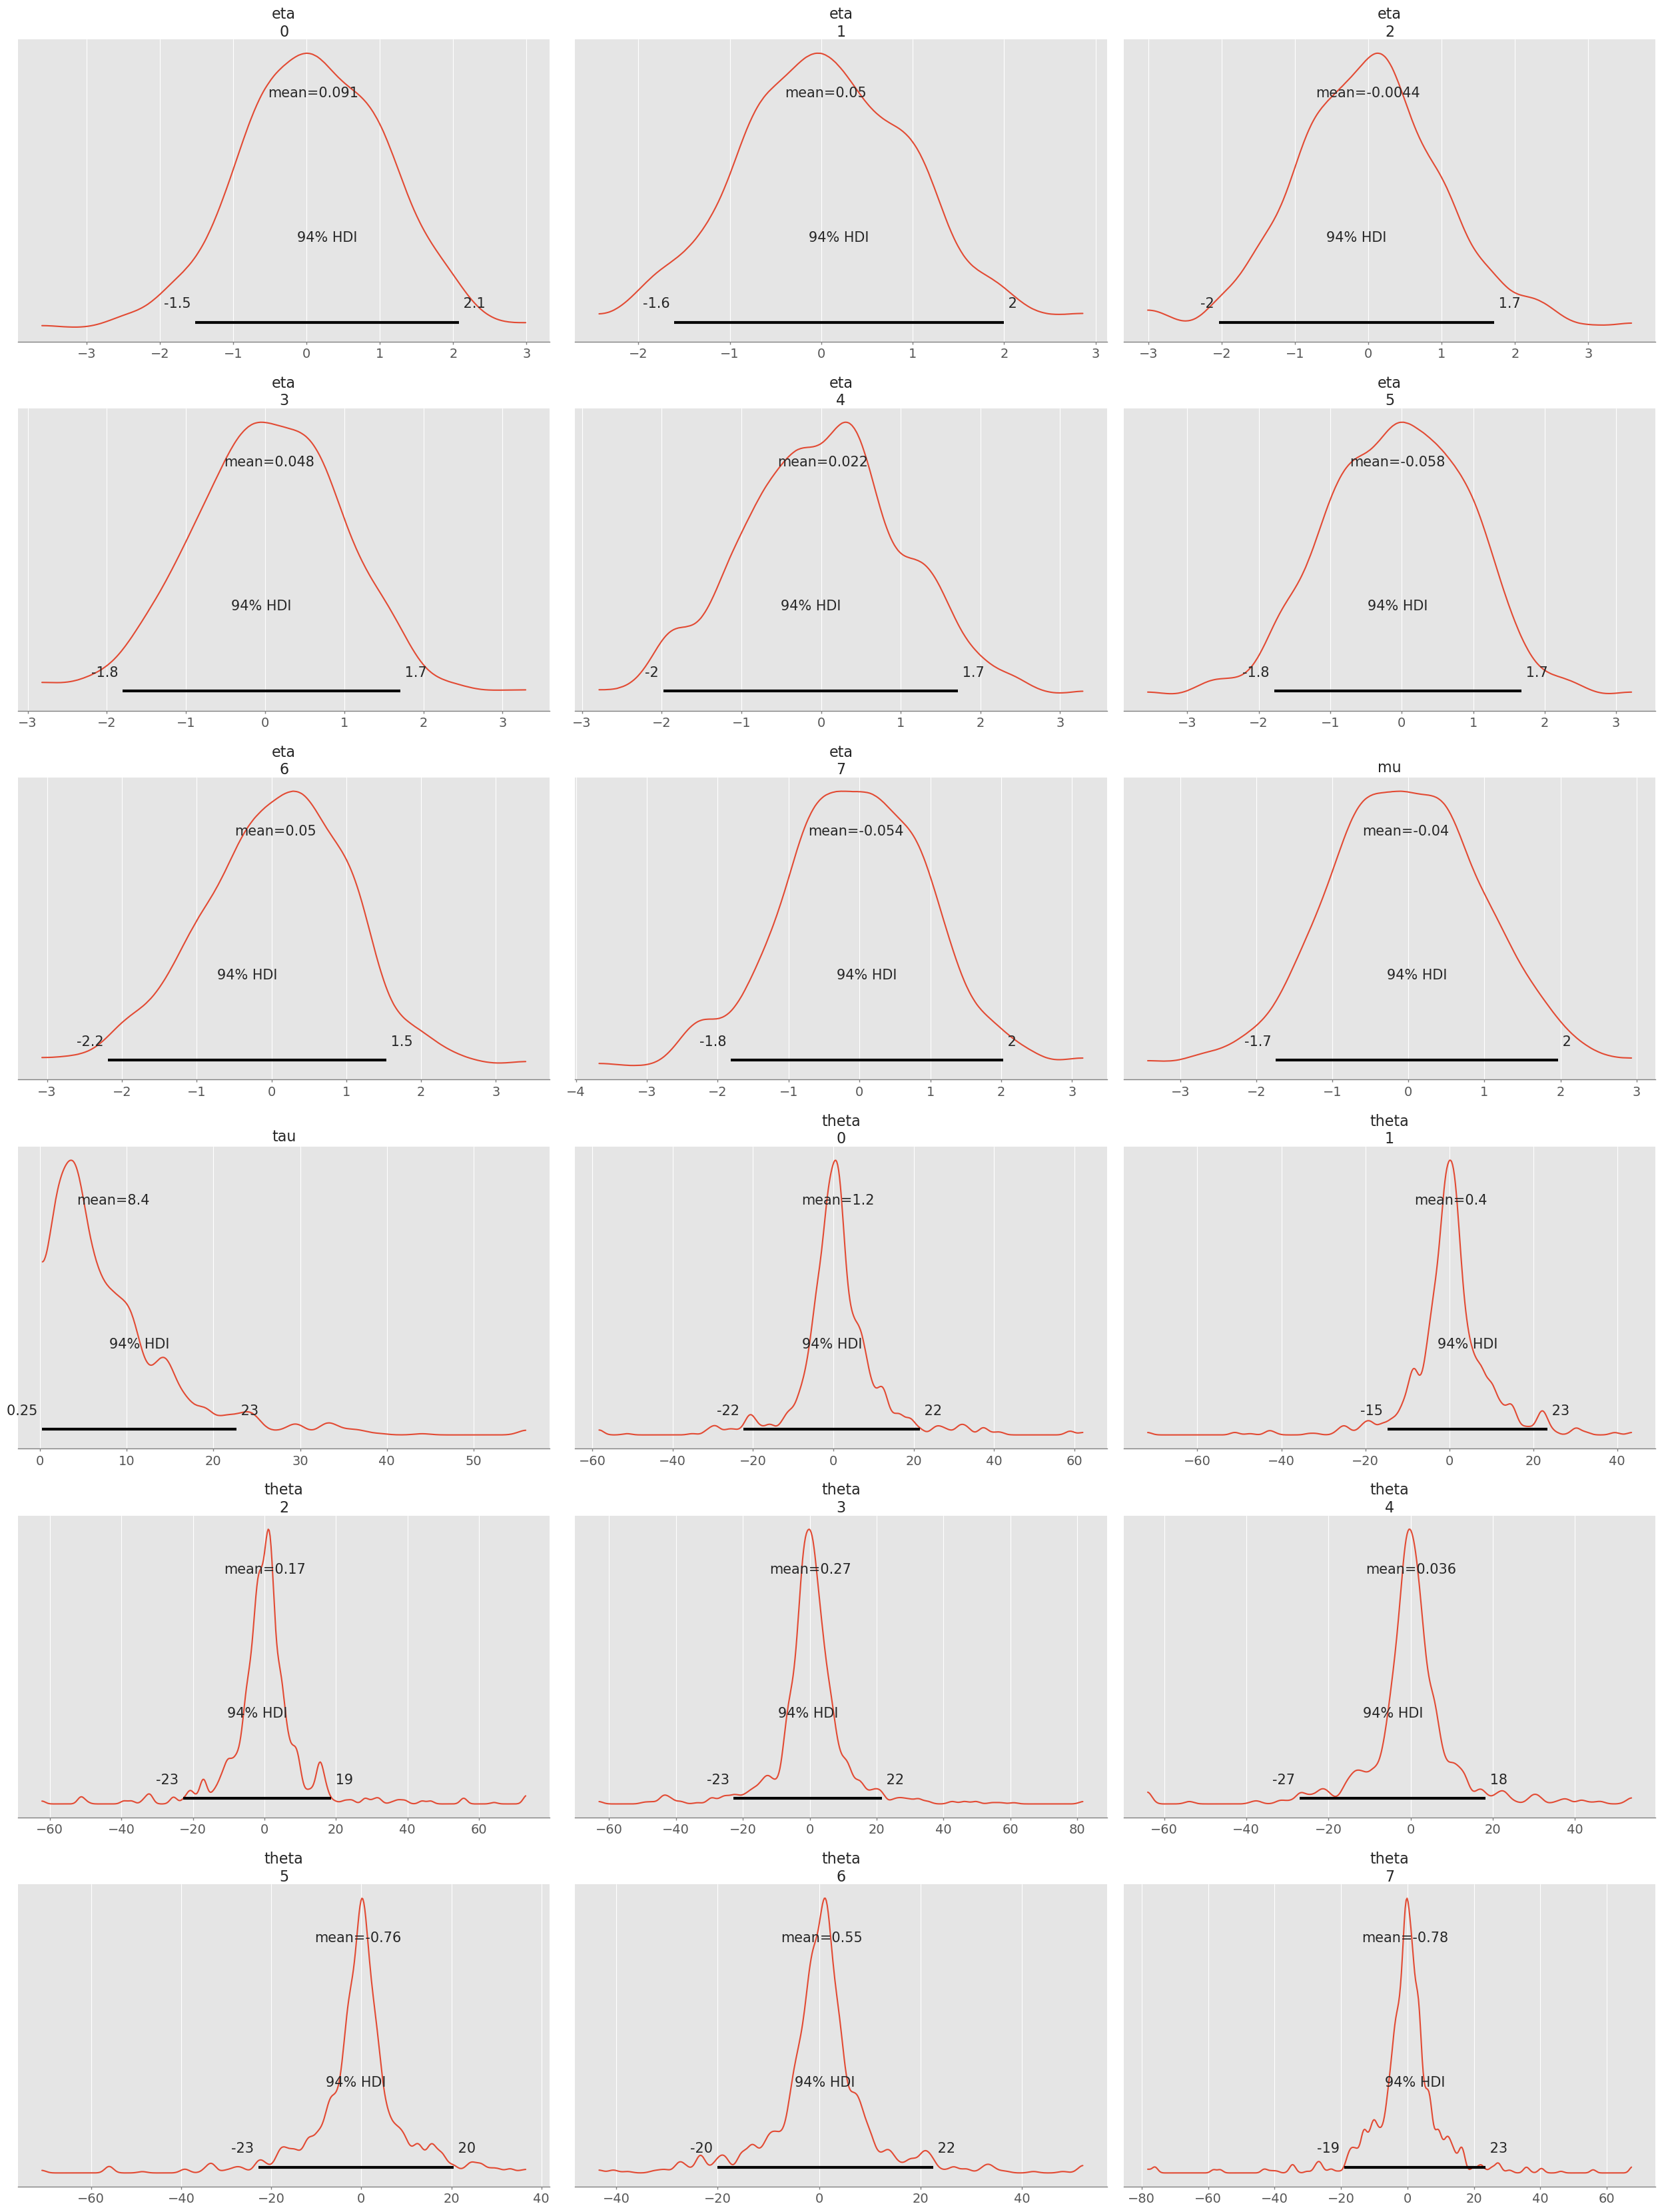

In [17]:
pm.plot_posterior(svgd_approx.sample(1000));

#### 1.2.2. $f$-divergence
Let ${\mathcal D}=\{x_{i}\}_{i=1}^{N}$ are $N$ observations.
The $f$-divergence between probability density functions, $q(\theta)$ and $p(\theta \vert \mathcal{D})$ is defined as,
$$
D_f(q(\theta) \parallel p(\theta \vert \mathcal{D})) = \int_\theta f \left(\frac{q(\theta)}{p(\theta \vert \mathcal{D})}\right) p(\theta \vert D)d\theta = \mathbb{E}_p \left[f \left(\frac{q(\theta)}{p(\theta\Vert \mathcal{D})}\right)\right]
$$
with $f(.)$ a convex function and $f(1)=0$.
A common instance of the $f$-divergence is the $\chi$-divergence: $f(x) = (x-1)^2$.

For VI using $\chi$-divergence, it is proposed to minimize {ref [1]}, 
$$
D_{\chi^2}(p\parallel q) = \mathbb{E}_{q(\mathbf{z};\mathbf{\Theta})}\left[\left(\frac{p(\mathbf{z}\vert \mathcal{D})}{q(\mathbf{z};\mathbf{\Theta})}\right)^2 - 1 \right]
$$

## References

<a id="References"></a>


<ol>
<li> Rubin, D. (1981). Estimation in Parallel Randomized Experiments. Journal of Educational Statistics, 6(4), 377-401. doi:10.2307/1164617 </li>
<li> Gelman, A., Carlin, J. B., Stern, H. S., Dunson, D. B., Vehtari, A., & Rubin, D. B. (2013). Bayesian data analysis. CRC press.</li>
</ol>
